# Importation

In [23]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import spacy


In [24]:
# df = pd.read_csv('../data/corpus.csv')

# Séparation test et entrainement

In [25]:
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# train_df.to_csv('../data/train.csv', index=False)
# test_df.to_csv('../data/test.csv', index=False)


### Ouvrir les csv qui ont déjà été divisés

In [26]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# Baseline 

### Prédiction aléatoire

In [27]:
def random_prediction():
    return random.choice(['Plat principal', 'Entrée', 'Dessert'])

test_df['random y_pred_spacy'] = test_df.apply(lambda x: random_y_pred_spacy(), axis=1)


### Prédiction classe majoritaire

In [28]:
def main_class_prediction(train_df):
    main_type = train_df['type'].mode()    
    return main_type

main_type = main_class_prediction(train_df)
test_df['main class prediction'] = test_df.apply(lambda x: main_type, axis=1)

# Model

### SKlearn + Tfi-Df

In [29]:
x_train = train_df['recette']
y_train = train_df['type']

model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())

model1.fit(x_train, y_train)

y_pred_Sklearn = model1.predict(test_df['recette'])

test_df['Tfi-Df prediction'] = y_pred_Sklearn

y_test = test_df['type']

### Spacy

In [30]:
nlp = spacy.load("fr_core_news_sm")

def spacy_tokenizer(text):
    tokens = nlp(text)
    return [token.lemma_ for token in tokens if not token.is_punct and not token.is_stop]

model2 = make_pipeline(TfidfVectorizer(tokenizer=spacy_tokenizer), SVC())

model2.fit(x_train, y_train)

y_pred_spacy = model2.predict(test_df['recette'])

test_df['Spacy prediction'] = y_pred_spacy


c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Résultat

### Random Prediction

Matrice de Confusion : 
      0    1    2
0  142  124  141
1  110  116  111
2  224  213  207


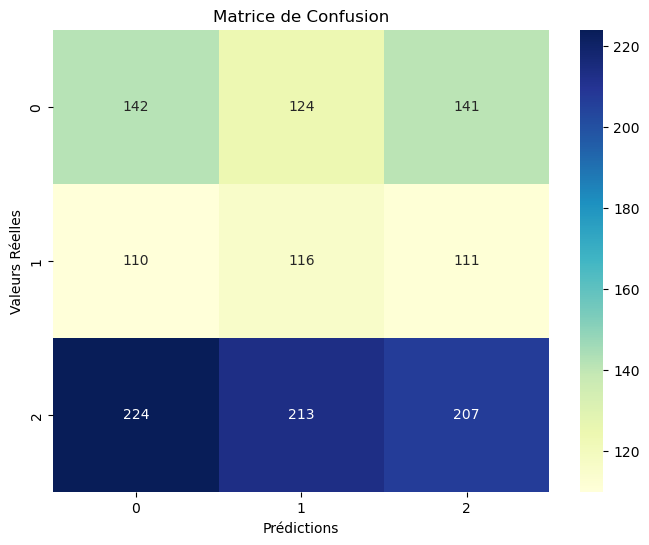

                precision    recall  f1-score   support

       Dessert       0.30      0.35      0.32       407
        Entrée       0.26      0.34      0.29       337
Plat principal       0.45      0.32      0.38       644

      accuracy                           0.34      1388
     macro avg       0.34      0.34      0.33      1388
  weighted avg       0.36      0.34      0.34      1388



In [31]:
y_rand = test_df['random prediction']

conf_matrix = confusion_matrix(y_test, y_rand)

conf_df = pd.DataFrame(conf_matrix)

print("Matrice de Confusion : \n", conf_df)

plt.figure(figsize=(8,6))
sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# Rappel - Precision - F1-score

report = classification_report(y_test, y_rand)
print(report)

### Main Class Prediction

Matrice de Confusion : 
    0  1    2
0  0  0  407
1  0  0  337
2  0  0  644


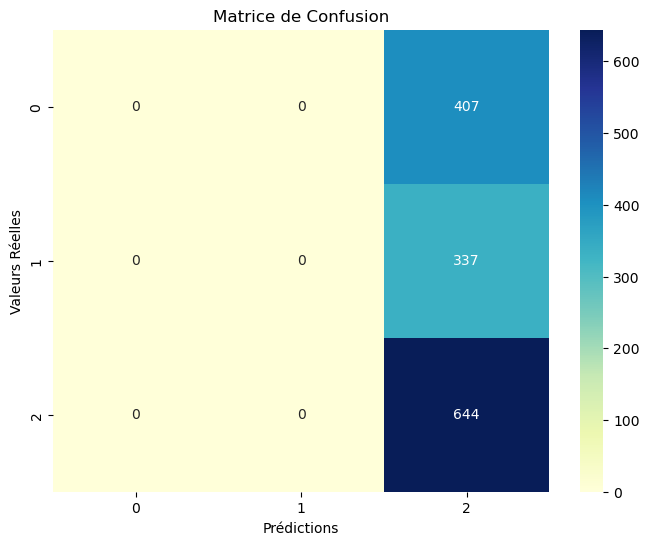

                precision    recall  f1-score   support

       Dessert       0.00      0.00      0.00       407
        Entrée       0.00      0.00      0.00       337
Plat principal       0.46      1.00      0.63       644

      accuracy                           0.46      1388
     macro avg       0.15      0.33      0.21      1388
  weighted avg       0.22      0.46      0.29      1388



c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
y_main = test_df['main class prediction']

conf_matrix = confusion_matrix(y_test, y_main)

conf_df = pd.DataFrame(conf_matrix)

print("Matrice de Confusion : \n", conf_df)

plt.figure(figsize=(8,6))
sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# Rappel - Precision - F1-score

report = classification_report(y_test, y_main)
print(report)

### Sklearn + Tfi-DF

Matrice de Confusion : 
                 Dessert  Entrée  Plat principal
Dessert             395       0              12
Entrée               14      24             299
Plat principal        6       2             636


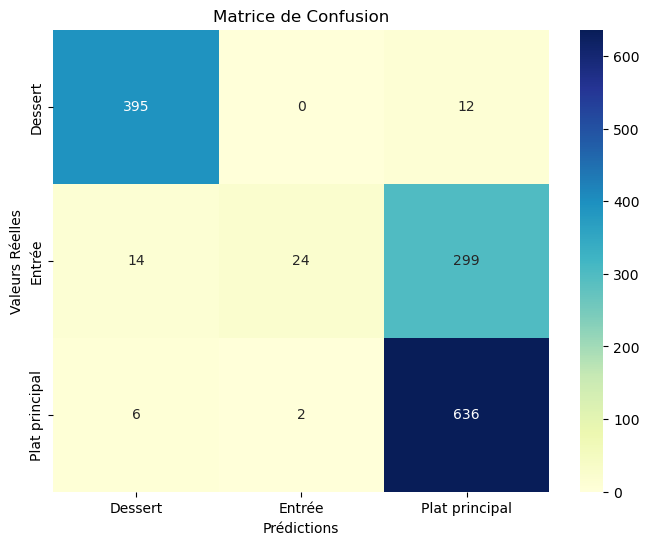

                precision    recall  f1-score   support

       Dessert       0.95      0.97      0.96       407
        Entrée       0.92      0.07      0.13       337
Plat principal       0.67      0.99      0.80       644

      accuracy                           0.76      1388
     macro avg       0.85      0.68      0.63      1388
  weighted avg       0.81      0.76      0.68      1388



In [33]:
conf_matrix = confusion_matrix(y_test, y_pred_Sklearn)

conf_df = pd.DataFrame(conf_matrix, index=model1.classes_, columns=model1.classes_)

print("Matrice de Confusion : \n", conf_df)

plt.figure(figsize=(8,6))
sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# Rappel - Precision - F1-score

report = classification_report(y_test, y_pred_Sklearn)
print(report)

### Spacy

Matrice de Confusion : 
                 Dessert  Entrée  Plat principal
Dessert             405       1               1
Entrée                5     233              99
Plat principal        5      61             578


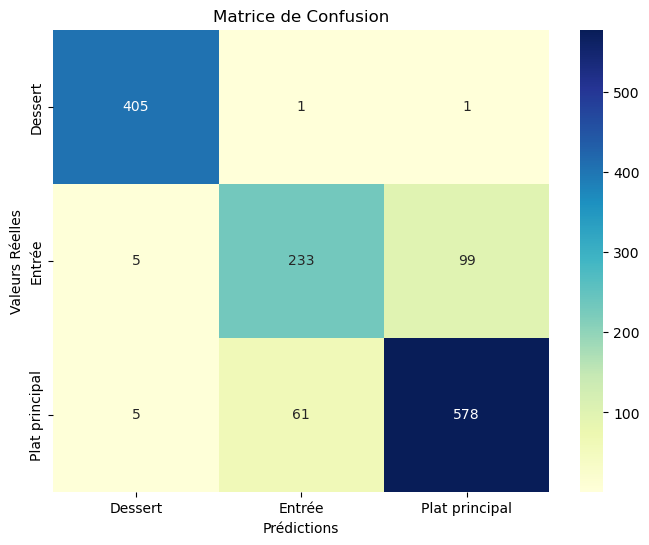

                precision    recall  f1-score   support

       Dessert       0.98      1.00      0.99       407
        Entrée       0.79      0.69      0.74       337
Plat principal       0.85      0.90      0.87       644

      accuracy                           0.88      1388
     macro avg       0.87      0.86      0.87      1388
  weighted avg       0.87      0.88      0.87      1388



In [34]:
conf_matrix = confusion_matrix(y_test, y_pred_spacy)

conf_df = pd.DataFrame(conf_matrix, index=model2.classes_, columns=model2.classes_)

print("Matrice de Confusion : \n", conf_df)

plt.figure(figsize=(8,6))
sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# Rappel - Precision - F1-score

report = classification_report(y_test, y_pred_spacy)
print(report)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Compute evaluation metrics
accuracy = accuracy_score(test_df["type"], y_pred_spacy)
precision = precision_score(test_df["type"], y_pred_spacy, average='weighted')
recall = recall_score(test_df["type"], y_pred_spacy, average='weighted')
f1 = f1_score(test_df["type"], y_pred_spacy, average='weighted')
conf_matrix = confusion_matrix(test_df["type"], y_pred_spacy)
class_report = classification_report(test_df["type"], y_pred_spacy)

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Evaluation Metrics:
Accuracy: 0.8760806916426513
Precision: 0.87347291188963
Recall: 0.8760806916426513
F1 Score: 0.8736867549379232
Confusion Matrix:
[[405   1   1]
 [  5 233  99]
 [  5  61 578]]
Classification Report:
                precision    recall  f1-score   support

       Dessert       0.98      1.00      0.99       407
        Entrée       0.79      0.69      0.74       337
Plat principal       0.85      0.90      0.87       644

      accuracy                           0.88      1388
     macro avg       0.87      0.86      0.87      1388
  weighted avg       0.87      0.88      0.87      1388

